# Image Segmentation with U-Net

We will be constructing our own U-Net, a CNN known for its efficiency in image segmentation tasks. Our objective is to predict a label for every individual pixel within an image from a self-driving car dataset. This process demands precision and accuracy, making it both challenging and rewarding. Let's delve into the world of U-Net and explore its potential in this context.

This project was completed as a component of the Deep Learning Specialization course offered on Coursera.

In [1]:
import tensorflow as tf
import numpy as np
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

### Load the data
First we will load the images

In [2]:
# get the absolute path to the directory 
path = ''
image_path = os.path.join(path, './CameraRGB/') 
mask_path = os.path.join(path, './CameraMask/')

# os.listdir() function is used to list all the files in a directory
image_list_orig = os.listdir(image_path)

# creates a list of absolute file paths for each image file in the 'CameraRGB' directory
image_list = [image_path+i for i in image_list_orig]

# creates a list of absolute file paths for each image file in the 'CameraMask' directory
mask_list = [mask_path+i for i in image_list_orig]

We will display some of the images

C:\Users\mabua\AppData\Local\Temp\ipykernel_15524\3642213812.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\mabua\AppData\Local\Temp\ipykernel_15524\3642213812.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

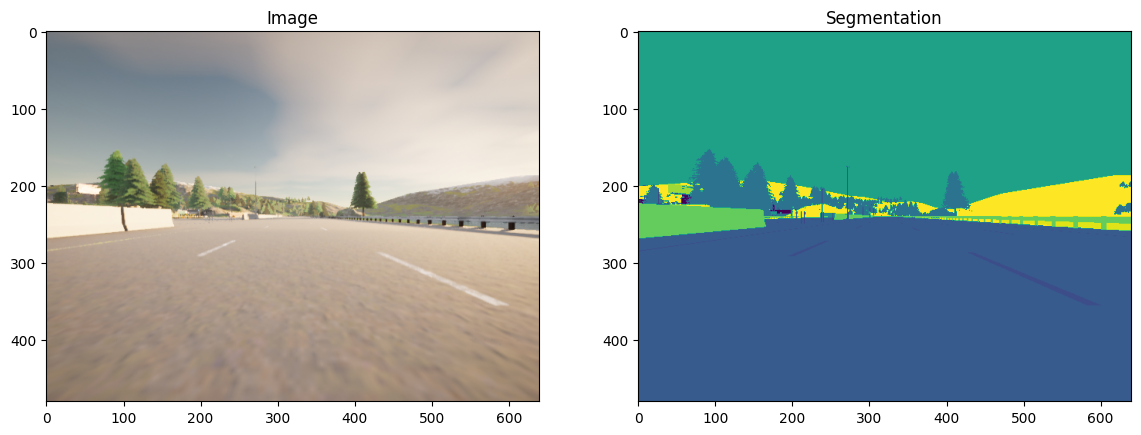

In [3]:
# get the images at index N = 2
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

# show the images
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### Create datasets

We will create a TensorFlow dataset from the list of image file paths.

This function does not load the actual data into memory but only creates a sequence of file path strings as tensors. Later, we can use these datasets to load and preprocess the actual image and mask data efficiently.

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

We will then create constant tensors of the images. 

The constant tensors store the file paths as static values in memory. Unlike the previous approach, this method does not create datasets. Instead, it directly stores the file path strings as tensors, allowing us to use these constant tensors as inputs to the TensorFlow models or for other operations within the computation graph.

In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

We will create another dataset, but this time the contents are tuples.

Each tuple contains an image file path and its corresponding mask file path.

In [6]:
# create a TensorFlow dataset of tuples
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

### Preprocess The Data

We will preprocess the data by implementing the following function. The function will take the file paths of an image and its corresponding mask as inputs. The function then reads and processes the image and mask using TensorFlow's image processing functions. The output of the function is a preprocessed image tensor and a preprocessed mask tensor.

We will use the following function in combination with the dataset we've created earlier to load, preprocess, and feed images and masks into the model during training or evaluation

In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)       # reads the contents of the image file
    img = tf.image.decode_png(img, channels=3) # decodes the raw image
    img = tf.image.convert_image_dtype(img, tf.float32) # converts the image tensor's data type to tf.float32, ensuring that the pixel values are in the range [0, 1]

    # do the same preprocessing to the mask files
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

The following is another preprocessing function that takes an image tensor and a mask tensor as inputs. The function performs preprocessing on both the image and the mask by resizing them to a specific size using nearest-neighbor interpolation. The output of the function is the preprocessed image tensor and the preprocessed mask tensor.

In [8]:
def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

### Data Pipline

Next we will be building a data processing pipeline using TensorFlow's Dataset API. This pipeline involves two stages of mapping:
* first, mapping the process_path function to the dataset to handle file ***reading*** and ***decoding*** 
* Then mapping the preprocess function to perform ***resizing*** and ***preparation***

In [9]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## U-Net Archeticture

<img src="pics/unet.png" style="width:700px;height:400;">

**Encoder with downsampling stages**

The initial phase involves guiding images through a sequence of convolutional layers, leading to the reduction of image height and width while simultaneously amplifying the channel count.

The contracting path adheres to a conventional Convolutional Neural Network (CNN) architecture. It encompasses convolutional layers, their associated activation functions, and pooling layers to decrease image size and distill its distinctive traits. Specifically, this involves iteratively employing two sets of 3 x 3 convolutions with same padding. Each convolution is subsequently followed by a Rectified Linear Unit (ReLU) activation and a 2 x 2 max pooling process that enacts downsampling. During each round of downsampling, the quantity of feature channels undergoes doubling.

**Decoder with upsampling phases**

The expanding path performs the reverse function of the contracting path. It reinstates the image's original dimensions while progressively reducing the channel count.

In detail, every phase in the expanding path executes an upscaling of the feature map, subsequently accompanied by a 2 x 2 convolution (transposed convolution). This transposed convolution achieves a halving of the feature channel number, while concurrently augmenting image height and width.

Subsequently, there's a concatenation with the corresponding cropped feature map derived from the contracting path, followed by two successive 3 x 3 convolutions, each succeeded by a Rectified Linear Unit (ReLU). Incorporating cropping is necessary to manage the loss of border pixels inherent in every convolution process.

Final Feature Mapping Block: In the ultimate layer, a 1x1 convolution is deployed to translate each 64-component feature vector into the specified number of classes. The channel dimensions from the previous layer correlate with the employed filter count. By employing 1x1 convolutions, it's feasible to transform that dimension by selecting an appropriate number of 1x1 filters. Upon applying this concept to the concluding layer, the channel dimensions can be diminished to facilitate one layer for each class.








The U-Net architecture is comprised of a cumulative total of 23 convolutional layers.

### Encoder

For the sake of computation, we will implement only the layers with red border in the following diagram. Or in other words, we will use two convolution layers instead of three

<img src="pics/encoder.png" style="width:500px;height:500;">

* Add 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to `he_normal`, `padding` set to **same** and **relu** activation.
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    # first conv layer 
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    # second conv layer
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### Decoder

The decoder takes expansive_input (input tensor from the previous layer) and contractive_input (input tensor from the previous skip layer) as arguments.

The number of filters used is the same as in the completed downsampling block.

* Applies a `Conv2DTranspose` layer with `n_filters`, using a `kernel size` of (3,3) and a `stride` of (2,2). `Padding` is set to "same". This layer is applied to expansive_input.
* Concatenates the output of the Conv2DTranspose layer to the contractive_input tensor along axis 3, creating a skip connection.
* The final component consists of two `Conv2D` layers with the same parameters used for the encoder: `ReLU activation`, `He normal` initializer, and `same padding`.

In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    # one Conv2DTranspose layer
    up = Conv2DTranspose(
                 n_filters, # number of filters
                 3,    # Kernel size
                 strides=(2, 2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    # 2 Conv2D layers
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    
    return conv

## U-Net

In the function `unet_model`, we specify the input shape, the number of filters, and the count of classes (which is 23 in this instance).

For the initial portion of the model:

- We start with a convolutional block that takes the model inputs and the filter count.
- Subsequently, we link the first output element of each block to the input of the subsequent convolutional block.
- We progressively double the number of filters at each stage.
- From `conv_block4` onward, we introduce a dropout probability of 0.3.
- In the final convolutional block, we maintain a dropout probability of 0.3 and deactivate the max pooling operation.

For the latter half:

- We utilize `cblock5` as `expansive_input` and `cblock4` as `contractive_input`, while using a factor of `n_filters * 8`. This establishes the bottleneck layer of the network.
- We link the output of the preceding block as `expansive_input`, along with the corresponding output of the contractive block.
- It's important to note that we must employ the second element of the contractive block before the max pooling layer.
- At each stage, we halve the number of filters compared to the previous block.
- `conv9` takes the form of a Conv2D layer, featuring ReLU activation, He normal initialization, and same padding.
- Finally, `conv10` is a Conv2D layer with the number of classes as filters, a kernel size of 1, and "same" padding. The output of `conv10` serves as the final output of our model.

In [15]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    # Input layer
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters)

    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)

    # Include a dropout_prob of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3) 

    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(expansive_input=cblock5[0], contractive_input=cblock4[1], n_filters=n_filters*8)

    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(expansive_input=ublock6, contractive_input=cblock3[1], n_filters=n_filters*4)
    ublock8 = upsampling_block(expansive_input=ublock7, contractive_input=cblock2[1], n_filters=n_filters*2)
    ublock9 = upsampling_block(expansive_input=ublock8, contractive_input=cblock1[1], n_filters=n_filters)

    # add a convolution layer
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, (1, 1), padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Set Model Dimensions

In [16]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [17]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

Compile the model

We will use Sparse Categorical Crossentropy

In [18]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We will define a function that allows you to display both an input image, and its ground truth

In [19]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


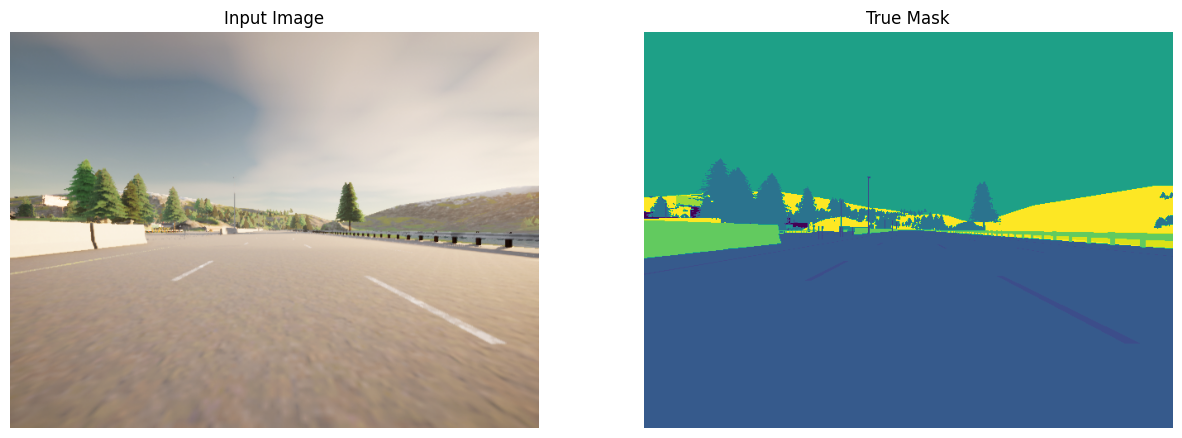

In [20]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Train the Model

In [21]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 224s 6s/step - loss: 1.9660 - accuracy: 0.5270
Epoch 2/5
34/34 [==============================] - 186s 5s/step - loss: 0.8434 - accuracy: 0.7950
Epoch 3/5
34/34 [==============================] - 210s 6s/step - loss: 0.5882 - accuracy: 0.8326
Epoch 4/5
34/34 [==============================] - 205s 6s/step - loss: 0.4744 - accuracy: 0.8575
Epoch 5/5
34/34 [==============================] - 195s 6s/step - loss: 0.4090 - accuracy: 0.8756


Create a function to get the highest probability prediction for each pixel

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis] # Add a new axis to the tensor
    return pred_mask[0]

## Plot Model Accuracy

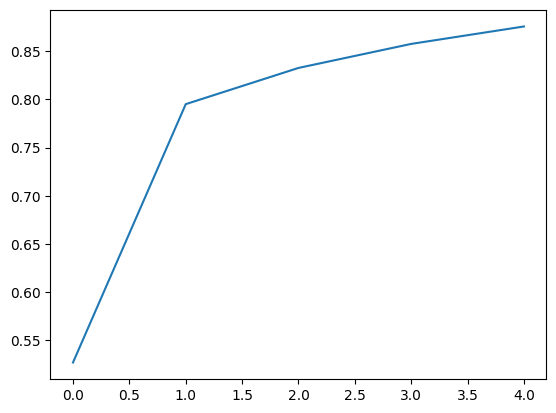

In [24]:
plt.plot(model_history.history["accuracy"])

Show Predictions

In [27]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


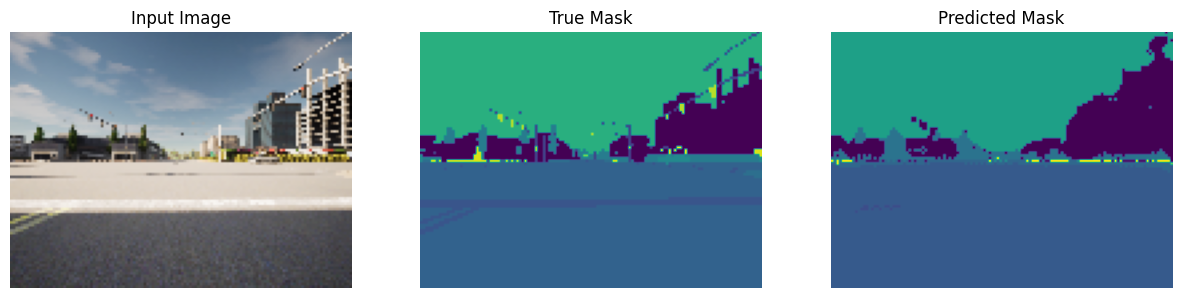

1/1 [==============================] - 1s 789ms/step


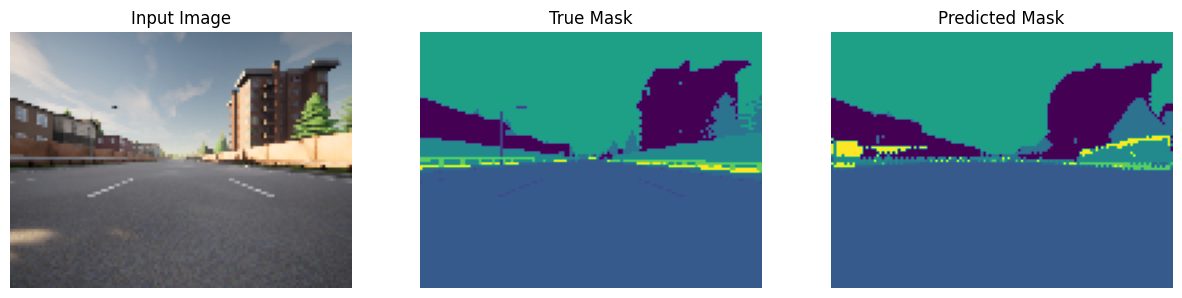

1/1 [==============================] - 1s 792ms/step


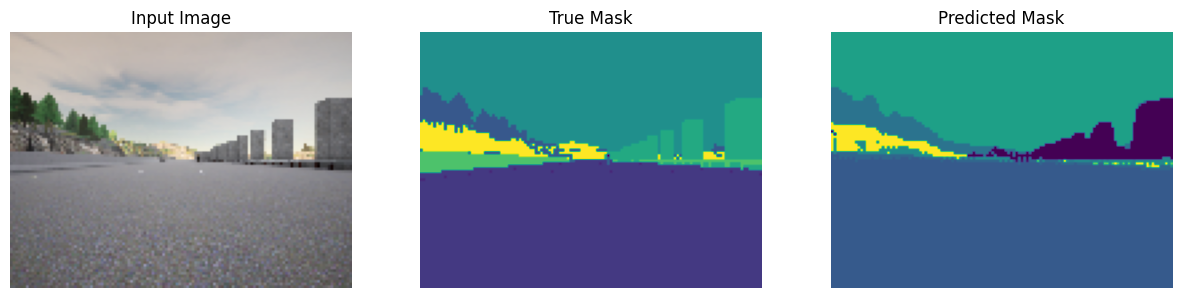

1/1 [==============================] - 1s 764ms/step


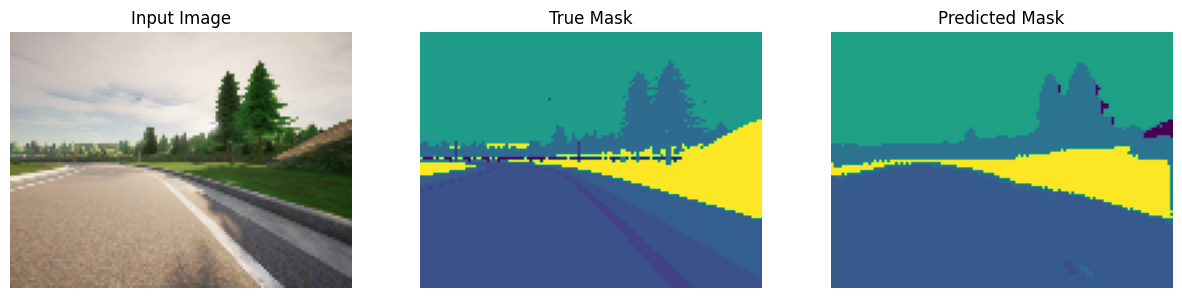

1/1 [==============================] - 1s 756ms/step


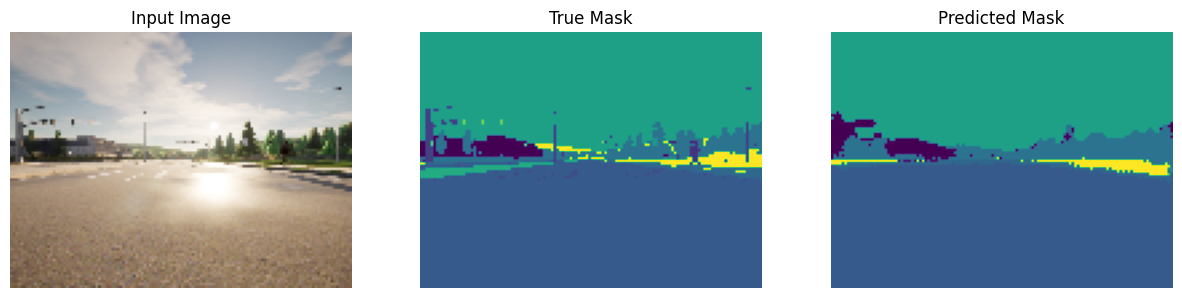

1/1 [==============================] - 1s 757ms/step


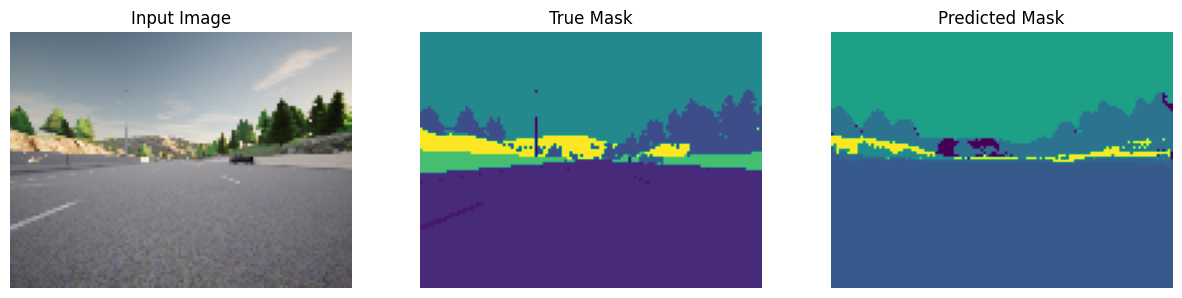

In [28]:
show_predictions(train_dataset, 6)